In [1]:
import pandas as pd

# Upload the data from the CSV files
cash_requests_df = pd.read_csv('../cleaned_dataset/modified_cash_requests_data.csv')
fees_df = pd.read_csv('../cleaned_dataset/modified_fees_data.csv')

# Convert the columns to datetime
cash_requests_df['created_at'] = pd.to_datetime(cash_requests_df['created_at'], utc=True)
fees_df['created_at'] = pd.to_datetime(fees_df['created_at'], utc=True)

# Creat one column of cash_requests_df based on the first transaction for each user
cash_requests_df['cohort'] = cash_requests_df.groupby('user_id')['created_at'].transform('min').dt.to_period('M')


C:\Users\m1557\AppData\Local\Temp\ipykernel_1420\3773291275.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_requests_df['cohort'] = cash_requests_df.groupby('user_id')['created_at'].transform('min').dt.to_period('M')


In [2]:
# Join fees_df with cash_requests_df using 'cash_request_id' and 'id'
fees_df = fees_df.merge(cash_requests_df[['id', 'cohort']], left_on='cash_request_id', right_on='id', how='left')

In [3]:

# Filter the fees to exclude those with 'rejected' or 'cancelled' status
fees_df = fees_df[~fees_df['status'].isin(['rejected', 'cancelled'])]



In [4]:
# Calculate the income generated by each cohort
cohort_revenue = fees_df.groupby('cohort')['total_amount'].sum().reset_index()
cohort_revenue.columns = ['Cohorte', 'Ingresos Generados']

cohort_revenue.head(10)

,Cohorte,Ingresos Generados
0,2019-11,30.0
1,2019-12,1135.0
2,2020-01,460.0
3,2020-02,640.0
4,2020-03,650.0
5,2020-04,1585.0
6,2020-05,3950.0
7,2020-06,14470.0
8,2020-07,11200.0
9,2020-08,5050.0


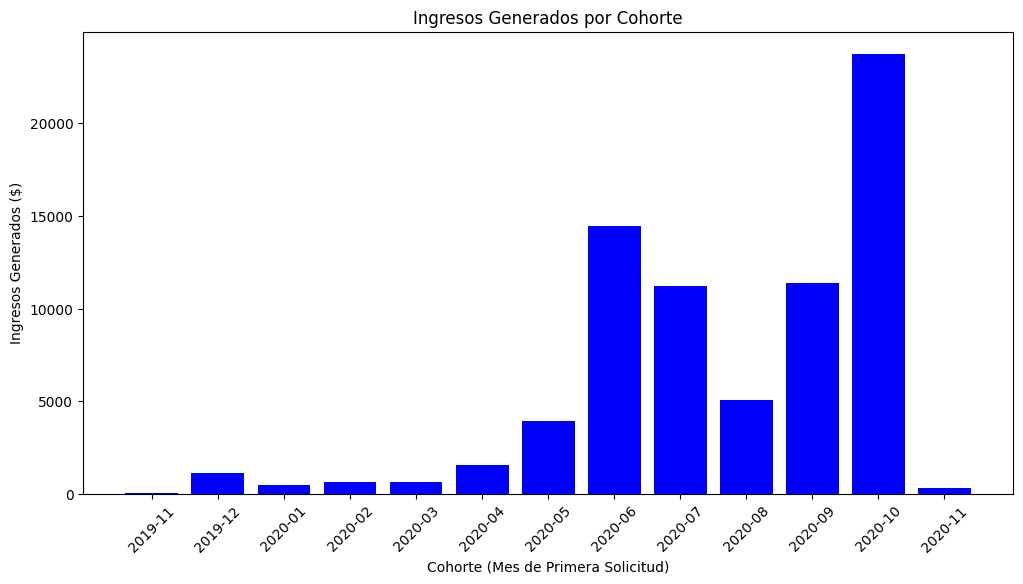

In [5]:
import matplotlib.pyplot as plt

# To plot the revenue for each cohort
plt.figure(figsize=(12, 6))
plt.bar(cohort_revenue['Cohorte'].astype(str), cohort_revenue['Ingresos Generados'], color='blue')
plt.xlabel('Cohorte (Mes de Primera Solicitud)')
plt.ylabel('Ingresos Generados ($)')
plt.title('Ingresos Generados por Cohorte')
plt.xticks(rotation=45)
plt.show()

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose 'created_at' is the date of the request creation and 'cohort' is the cohort based on this date
# Make sure 'created_at' and 'cohort' are in the correct format
fees_df['month'] = fees_df['created_at'].dt.to_period('M')

# Group by cohort and month to sum up the income
cohort_income_monthly = fees_df.groupby(['cohort', 'month'])['total_amount'].sum().reset_index()

# Create a complete range of months and cohorts
all_months = pd.period_range(start='2019-11', end=fees_df['month'].max(), freq='M')
all_cohorts = pd.period_range(start='2019-11', end=fees_df['cohort'].max(), freq='M')

# Create a multi-index with all combinations of cohorts and months
multi_index = pd.MultiIndex.from_product([all_cohorts, all_months], names=['cohort', 'month'])

# Reindex the DataFrame to include all combinations and fill missing values with 0
cohort_income_monthly = cohort_income_monthly.set_index(['cohort', 'month']).reindex(multi_index, fill_value=0).reset_index()

# Pivot the data for the heatmap
pivot_income = cohort_income_monthly.pivot(index='cohort', columns='month', values='total_amount')

# Create a mask to hide values that precede the cohort month
mask = np.zeros(pivot_income.shape, dtype=bool)
for i, cohort in enumerate(pivot_income.index):
    mask[i, :i] = True


C:\Users\m1557\AppData\Local\Temp\ipykernel_1420\1735281219.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fees_df['month'] = fees_df['created_at'].dt.to_period('M')


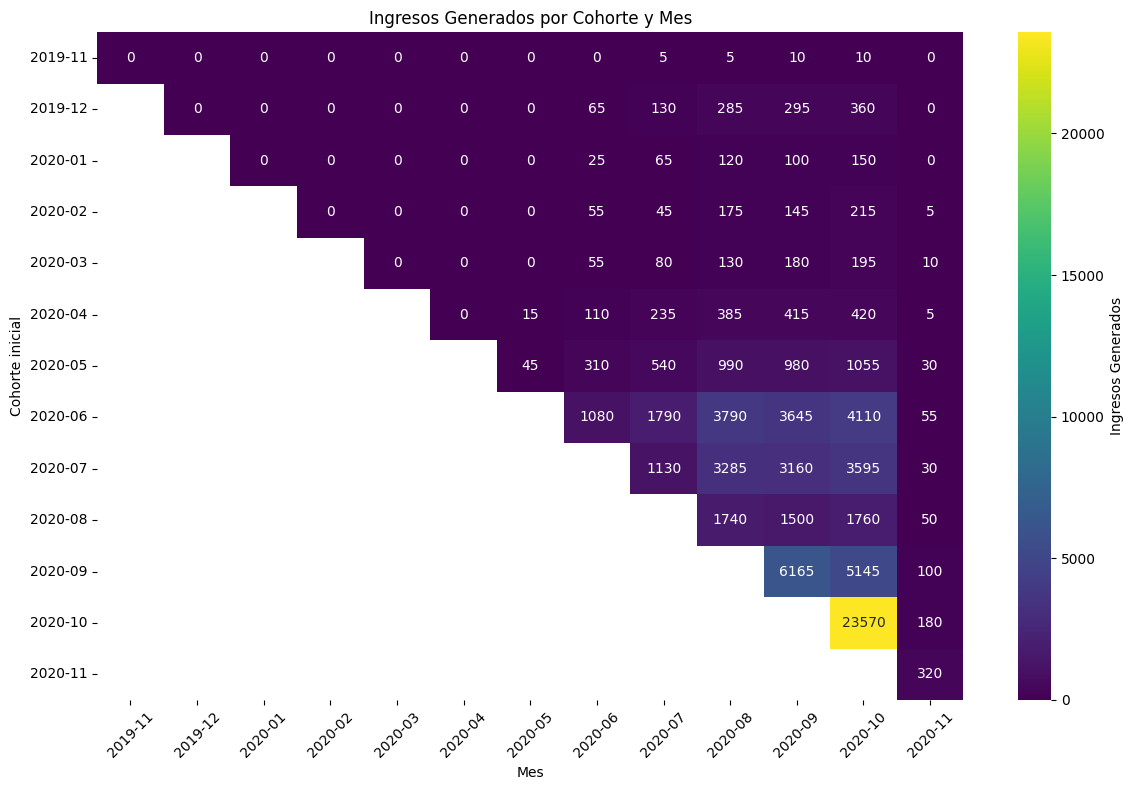

In [17]:
# Create the heatma
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_income, cmap='viridis', annot=True, fmt=".0f", mask=mask, cbar_kws={'label': 'Ingresos Generados'})
plt.title('Ingresos Generados por Cohorte y Mes')
plt.xlabel('Mes')
plt.ylabel('Cohorte inicial')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()